# Data Cleaning & Augmentation

## Simplify chords

Simplifying chords down to 42: base note (A-G) + accidental + major/minor(dim).

In [4]:
import pandas as pd
import numpy as np
import json
import csv
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
### Simplifying chords down to set of 42 ###
notes = ["A", "B", "C", "D", "E", "F", "G"]
accs = ["b", "s", ""]
all_notes_list = [note + acc for note in notes for acc in accs]

def simplify_chord(chord: str) -> str:
    """
    Removes chord quality from a chord.
    """
    for note in all_notes_list:
        if not chord.startswith(note):
            continue

        suffix = chord.removeprefix(note)
        if suffix.startswith("min") or suffix.startswith("dim"):
            return note + "min"
        else:
            return note

    if chord == "sC":
        return "Cs"

    # print(chord)
    return ""

In [ ]:
df = pd.read_csv("chordonomicon_v2.csv", usecols=["id", "chords", "main_genre"])
df["chords"] = (
    df["chords"]
    .str.split(" ")
    .map(lambda lst: [simplify_chord(x) for x in lst if not x.startswith("<")])
)
df.to_csv("chordonomicon_v2_simplified.csv", index=False)

/var/folders/d6/01g3p5bx5m1cs2jjn1_kw59c0000gn/T/ipykernel_6589/3360250008.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("chordonomicon_v2.csv", usecols=["id", "chords", "main_genre"])


Optionally, also collaps both sharp and flat accents to sharp:

In [ ]:
def simplify_and_standardize(chord: str) -> str:
    """
    Simplifies chord quality (min/dim) and standardizes flat prefixes.
    """
    # --- 1) Simplification (your original simplify_chord) ---
    simplified = ""
    for note in all_notes_list:
        if chord.startswith(note):
            suffix = chord[len(note):]
            if suffix.startswith("min") or suffix.startswith("dim"):
                simplified = note + "min"
            else:
                simplified = note
            break

    if chord == "sC":
        simplified = "Cs"

    if simplified == "":
        simplified = chord  # fallback to original if nothing matched

    # --- 2) Standardization (your standardize_chord_prefix) ---
    flat_to_sharp = {
        "Bb": "As",
        "Db": "Cs",
        "Eb": "Ds",
        "Gb": "Fs",
        "Ab": "Gs",
        "Cb": "B",
        "Fb": "E",
        "Bs": "C",
        "Es": "F"
    }

    for flat, sharp in flat_to_sharp.items():
        if simplified.startswith(flat):
            return sharp + simplified[len(flat):]

    return simplified


In [ ]:
df = pd.read_csv("chordonomicon_v2.csv", usecols=["id", "chords", "main_genre"])
df["chords"] = (
    df["chords"]
    .str.split(" ")
    .map(lambda lst: [simplify_and_standardize(x) for x in lst if not x.startswith("<")])
)
df.to_csv("chordonomicon_v2_standardized.csv", index=False)

/var/folders/d6/01g3p5bx5m1cs2jjn1_kw59c0000gn/T/ipykernel_1240/3026761472.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("chordonomicon_v2.csv", usecols=["id", "chords", "main_genre"])


## Transpose to all chords
Transpose each song to mitigate bias from the key of the song and to augment our data. Also Collapse both sharp and flat accents to sharp

In [ ]:
### Transposing songs to all keys ###
keys_list = ["C", "Cs", "D", "Ds", "E", "F", "Fs", "G", "Gs", "A", "As", "B"]

def transpose_chord(chord: str, variation: int) -> str:
    # Identify base note and suffix robustly
    if len(chord) >= 2 and chord[1] == "s":
        base = chord[:2]
        suffix = chord[2:]
    else:
        base = chord[:1]
        suffix = chord[1:]
    if base in keys_list:
        idx = keys_list.index(base)
        new_base = keys_list[(idx + variation) % 12]
        return new_base + suffix
    return chord  # If not found, return as is

def augment_keys(df):
    augmented_rows = []
    for _, row in df.iterrows():
        for variation in range(12):
            new_row = row.copy()
            if variation == 0:
                new_row["original_key"] = True
            else:
                new_row["original_key"] = False
            new_row["added_semitones"] = variation
            new_row["chords"] = [transpose_chord(chord, variation) for chord in row["chords"]]
            augmented_rows.append(new_row)
    return pd.DataFrame(augmented_rows)

def standardize_chord_prefix(chord: str) -> str:
    # Map flat notes to their sharp equivalents
    flat_to_sharp = {
        "Bb": "As",
        "Db": "Cs",
        "Eb": "Ds",
        "Gb": "Fs",
        "Ab": "Gs",
        "Cb": "B",
        "Fb": "E",
        "Bs": "C",
        "Es": "F"
    }
    for flat, sharp in flat_to_sharp.items():
        if chord.startswith(flat):
            return sharp + chord[len(flat):]
    return chord

In [ ]:
# Writing transposed dataset to csv
def get_pop_chords_df():
    df = pd.read_csv("hf://datasets/ailsntua/Chordonomicon/chordonomicon_v2.csv",usecols=["id", "chords", "main_genre"])
    pop_df = df[df["main_genre"] == "pop"][["id", "chords"]].copy()
    pop_df["chords"] = pop_df["chords"].str.split(" ")
    pop_df["chords"] = pop_df["chords"].map(
        lambda chords: [simplify_chord(standardize_chord_prefix(chord)) for chord in chords if not chord.startswith("<")]
    )

    pop_df["original_key"] = True
    pop_df["added_semitones"] = 0
    return pop_df

pop_chords_df = get_pop_chords_df()
augmented_df = augment_keys(pop_chords_df)
print(augmented_df.head(15))
augmented_df.to_csv("chordonomicon_v2_augmented.csv", index=False)

/var/folders/d6/01g3p5bx5m1cs2jjn1_kw59c0000gn/T/ipykernel_1240/484076371.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("hf://datasets/ailsntua/Chordonomicon/chordonomicon_v2.csv",usecols=["id", "chords", "main_genre"])


# N-gram Learning
Compute n-gram counts using CountVectorizer library (usually used for bag of n-grams)

In [6]:
def count_n_grams(data, n: int = 1) -> pd.DataFrame:
    word_vectorizer = CountVectorizer(
        ngram_range=(1, n),
        analyzer="word",
        token_pattern=r"(?u)\b\w+\b",
        lowercase=False,
    )

    sparse_matrix = word_vectorizer.fit_transform(
        data.map(lambda chords: " ".join(chords))
    )

    frequencies = sum(sparse_matrix).toarray()[0]

    df_all = pd.DataFrame(
        frequencies,
        index=word_vectorizer.get_feature_names_out(),
        columns=["count"],
    )

    return df_all.groupby(by=lambda chords: len(chords.split(" ")))

Import our processed dataset and compute n-gram counts.

In [8]:
import pandas as pd
import ast
import json

def load_chords_from_csv(path):
    df = pd.read_csv(path, usecols=['chords'])
    # If chords are stored as a list string, use ast.literal_eval
    try:
        chords = df['chords'].apply(ast.literal_eval)
    except Exception:
        chords = df['chords'].str.split(" ")
    return chords


In [ ]:
results = {}
test_datasets = {} # Store test sets for evaluation

for name, path in [
    ("simplified", "chordonomicon_v2_simplified.csv"),
    ("standardized", "chordonomicon_v2_standardized.csv"),
    ("augmented", "chordonomicon_v2_augmented.csv")
]:
    chords = load_chords_from_csv(path)
    
    # Train/Test Split (90/10)
    split_idx = int(len(chords) * 0.9)
    train_chords = chords[:split_idx]
    test_chords = chords[split_idx:]
    test_datasets[name] = test_chord

In [ ]:
results = {}
test_datasets = {} # Store test sets for evaluation

for name, path in [
    ("simplified", "chordonomicon_v2_simplified.csv"),
    ("standardized", "chordonomicon_v2_standardized.csv"),
    ("augmented", "chordonomicon_v2_augmented.csv")
]:
    chords = load_chords_from_csv(path)
    
    # Train/Test Split (90/10)
    split_idx = int(len(chords) * 0.9)
    train_chords = chords[:split_idx]
    test_chords = chords[split_idx:]
    test_datasets[name] = test_chords
    
    # Compute counts on TRAIN only
    n_gram_counts = count_n_grams(train_chords, 3)
    
    results[name] = {}
    for key, _ in n_gram_counts:
        df = n_gram_counts.get_group(key).sort_values(by='count')
        results[name][f"{key}-gram"] = df.reset_index().to_dict(orient="records")
        if name == "simplified":
            simplified_n_gram_counts = n_gram_counts
            print(f"\n--- {key}-gram counts for simplified (TRAIN) ---")
            print(df)

with open("n_gram_counts_results.json", "w") as f:
    json.dump(results, f, indent=2)


--- 1-gram counts for simplified (TRAIN) ---
         count
Gbmin    12189
Dbmin    22967
Bs       38982
Abmin    44209
Es       47947
Asmin    68417
Ebmin    86344
Gb      100193
Dsmin   119746
Bbmin   150710
Db      196674
Fmin    304323
Gsmin   324333
As      328361
Ds      336439
Gs      346267
Ab      361257
Cs      413967
Cmin    422243
Eb      511595
Gmin    573415
Csmin   624833
Fs      758529
Fsmin   882484
Bb     1012555
Dmin   1276824
Bmin   1451949
B      1581012
Emin   2657899
E      2846983
Amin   2916823
F      3319048
A      4060730
D      5379310
C      5939345
G      6907654

--- 2-gram counts for simplified (TRAIN) ---
               count
Dsmin Gbmin        1
Asmin Gbmin        1
Gsmin Gbmin        1
Ds Gbmin           1
Dbmin Dsmin        1
...              ...
F C          1143106
D G          1435296
G D          1568284
G C          1694152
C G          1989728

[1291 rows x 1 columns]

--- 3-gram counts for simplified (TRAIN) ---
              count
Eb Gb Emin

Calculate transition matrix probabilities using counts.

In [13]:
import itertools

# base notes and shape of chord names
notes = ["A", "B", "C", "D", "E", "F", "G"]
# standardized/augmented: no flat spellings (only natural + sharp 's')
accs_std = ["", "s"]
# simplified: include flats 'b' in addition to sharps and naturals
accs_simpl = ["", "s", "b"]
third = ["", "min"]

# exclude weird/duplicate forms for standardized (same as you used)
excluded_chords = {"Bs", "Bsmin", "Es", "Esmin", "Cb", "Cbmin", "Fb", "Fbmin"}

# build standardized / augmented list
all_chords_std = [note + acc + t for note in notes for acc in accs_std for t in third]
all_chords_std = [c for c in all_chords_std if c not in excluded_chords]

# build simplified list (includes flats)
all_chords_simpl = [note + acc + t for note in notes for acc in accs_simpl for t in third]
all_chords_simpl = [c for c in all_chords_simpl if c not in excluded_chords]

# final dict
all_chords_dict = {
    "standardized": sorted(all_chords_std),
    "augmented": sorted(all_chords_std),   # same as standardized
    "simplified": sorted(all_chords_simpl),
}

print("standardized (count):", len(all_chords_dict["standardized"]))
print(all_chords_dict["standardized"])
print("simplified (count):", len(all_chords_dict["simplified"]))
print(all_chords_dict["simplified"])

standardized (count): 24
['A', 'Amin', 'As', 'Asmin', 'B', 'Bmin', 'C', 'Cmin', 'Cs', 'Csmin', 'D', 'Dmin', 'Ds', 'Dsmin', 'E', 'Emin', 'F', 'Fmin', 'Fs', 'Fsmin', 'G', 'Gmin', 'Gs', 'Gsmin']
simplified (count): 34
['A', 'Ab', 'Abmin', 'Amin', 'As', 'Asmin', 'B', 'Bb', 'Bbmin', 'Bmin', 'C', 'Cmin', 'Cs', 'Csmin', 'D', 'Db', 'Dbmin', 'Dmin', 'Ds', 'Dsmin', 'E', 'Eb', 'Ebmin', 'Emin', 'F', 'Fmin', 'Fs', 'Fsmin', 'G', 'Gb', 'Gbmin', 'Gmin', 'Gs', 'Gsmin']


In [14]:
# Calculate transition matrix probabilities
# alpha is additive smoothing

def compute_unigram_prob(n_gram_counts, alpha=1.0, input_data="simplified"):
    unigram = n_gram_counts.get_group(1)
    unigram = unigram.reindex(all_chords_dict[input_data], fill_value=0)
    vocab_size = len(all_chords_dict[input_data])
    total_count = unigram["count"].sum()

    probs = (unigram["count"] + alpha) / (total_count + alpha * vocab_size)
    df = pd.DataFrame([probs.values], 
                      index=[""],
                      columns=all_chords_dict[input_data])
    return df

In [15]:
def compute_unigram_prob_from_df(unigram_df: pd.DataFrame, alpha: float = 1.0, input_data: str = "simplified") -> pd.DataFrame:
    """
    Compute unigram probabilities with additive smoothing directly from a DataFrame.
    
    Parameters:
    - unigram_df: DataFrame containing columns ['index', 'count', ...] for 1-grams
    - alpha: additive smoothing constant
    - input_data: key to select chord vocabulary from all_chords_dict
    
    Returns:
    - DataFrame: 1-row, columns = chords, values = probability
    """
    # Set index to chord names
    unigram_df = unigram_df.set_index("index")

    # Reindex to include all possible chords, fill missing with 0
    vocab = all_chords_dict[input_data]
    unigram_df = unigram_df.reindex(vocab, fill_value=0)

    # Compute probabilities with additive smoothing
    total_count = unigram_df["count"].sum()
    probs = (unigram_df["count"] + alpha) / (total_count + alpha * len(vocab))

    # Return as a 1-row DataFrame with chords as columns
    return pd.DataFrame([probs.values], columns=vocab, index=[""])


In [ ]:
# Extract unigrams from df_all
unigram_df = simplified_n_gram_counts.get_group(1).reset_index().copy()

# Compute probabilities
unigram_probs = compute_unigram_prob_from_df(unigram_df, alpha=1.0, input_data="simplified")

print(unigram_probs)


In [17]:
import itertools
import pandas as pd

def compute_ngram_prob_from_df(ngram_df, n: int = 2, alpha=1.0, input_data="simplified"):
    """
    Compute n-gram probabilities from a reconstructed DataFrame.
    ngram_df: DataFrame with columns ['index', 'count', 'ngram_length'] for n-grams
    """
    ngram = ngram_df.copy()

    # use the 'index' column as the n-gram string
    ngram["evidence"] = ngram["index"].map(lambda s: " ".join(s.split()[:-1]))
    ngram["next"] = ngram["index"].map(lambda s: s.split()[-1])

    # generate all possible (n-1)-length sequences
    all_evidence_seq = [" ".join(evidence) for evidence in itertools.product(all_chords_dict[input_data], repeat=(n - 1))]
    full_index = pd.MultiIndex.from_product([all_evidence_seq, all_chords_dict[input_data]], names=["evidence", "next"])

    # reindex to include all possible n-grams
    ngram = ngram.set_index(["evidence", "next"])
    ngram = ngram.reindex(full_index, fill_value=0)

    # compute probabilities with additive smoothing
    evidence_counts = ngram["count"].groupby(level="evidence").transform("sum")
    vocab_size = len(all_chords_dict[input_data])
    ngram["prob"] = (ngram["count"] + alpha) / (evidence_counts + alpha * vocab_size)

    # return as a 2D DataFrame: rows=evidence, columns=next chord
    return ngram["prob"].unstack(fill_value=0.0)


In [ ]:
bigram_df = df_all[df_all["ngram_length"] == 2].copy()
bigram_probs = compute_ngram_prob_from_df(bigram_df, n=2, alpha=1.0, input_data="simplified")
print(bigram_probs.shape)
bigram_probs


In [ ]:
trigram_df = df_all[df_all["ngram_length"] == 3].copy()
trigram_probs = compute_ngram_prob_from_df(trigram_df, n=3, alpha=1.0, input_data="simplified")
print(trigram_probs.shape)
trigram_probs

# Inference
Deterministic and probabilistic methods, we are generating a 16 chord song simply from the log-probabilities from our models.

In [25]:
def deterministic_inference(evidence):
    # evidence: string of n-1 space-separated chords
    
    n = len(evidence.split()) + 1
    ngram_probs = unigram_probs if n == 1 else (bigram_probs if n == 2 else trigram_probs)

    if evidence not in ngram_probs.index:
        raise KeyError(f"Evidence '{evidence}' not found in {n}-gram table")
    
    row_probs = ngram_probs.loc[evidence]
    return row_probs.idxmax() # returns next chord w highest prob, if there are several, the first one in col order

def probabilistic_inference(evidence):
    # evidence: string of n-1 space-separated chords
    
    n = len(evidence.split()) + 1
    ngram_probs = unigram_probs if n == 1 else (bigram_probs if n == 2 else trigram_probs)

    if evidence not in ngram_probs.index:
        raise KeyError(f"Evidence '{evidence}' not found in {n}-gram table")
    
    row_probs = ngram_probs.loc[evidence]
    cdf = np.cumsum(row_probs.values) # create cumulative distribution over next possible chord

    # sample over dist
    seed = np.random.random()
    idx = np.searchsorted(cdf, seed)
    
    return row_probs.index[idx] # return probabilistically chosen next chord

In [ ]:
### test inference for bigram ###
seq = []

for _ in range(16):
    if len(seq) == 0:
        evidence = ""
    elif len(seq) == 1:
        evidence = seq[-1]
    else:
        evidence = " ".join(seq[-2:])

    next_chord = deterministic_inference(evidence) # can change to deterministic_inference()
    seq.append(next_chord)

print(seq)

In [ ]:
### test inference for bigram ###
seq = []

for _ in range(16):
    if len(seq) == 0:
        evidence = ""
    elif len(seq) == 1:
        evidence = seq[-1]
    else:
        evidence = " ".join(seq[-2:])

    next_chord = probabilistic_inference(evidence) # can change to deterministic_inference()
    seq.append(next_chord)

print(seq)

# Evaluation
Evaluate log-likelihood of an n-gram given a song (in this case the first song of the dataset)

In [28]:
def song_log_likelihood_ngram(song, n, ngram_probs):
    # song: list of chords in song
    # n: order of the n-gram model
    # ngram_probs: dict[context_tuple] -> dict[target] = P(target | context)
    # ex: trigram ngram_prob = dict[(chord1, chord2)] = {chord0:P,...,chordV:P}, dict[chord3] = P(chord3 | chord1, chord2)
    # vocab_size: 42 or 36?

    ll = 0.0
    if len(song) < n:
        return 0.0

    for t in range(n-1, len(song)):
        if n == 1:
            context = ""
        else:
            context = " ".join(song[t-(n-1):t])

        target = song[t]

        try:
            p = ngram_probs.loc[context, target]
        except KeyError:
            print(f"KeyError given evidence {context}")
            p = 1e-12

        if p <= 0:
            p = 1e-12
        
        ll += np.log(p)

    return ll

In [ ]:
# test log-likelihood
song_simplified = ['C', 'F', 'C', 'E', 'Amin', 'C', 'F', 'C', 'G', 'C', 'F', 'C', 'E', 'Amin', 'C', 'F', 'G', 'C', 'F', 'C', 'E', 'Amin', 'C', 'F', 'C', 'G', 'C', 'F', 'C', 'E', 'Amin', 'C', 'F', 'G', 'C', 'F', 'C', 'F', 'C', 'G', 'C', 'F', 'C', 'E', 'Amin', 'C', 'F', 'G', 'C', 'D', 'G', 'D', 'G', 'D', 'A', 'D', 'G', 'D', 'Fs', 'Bmin', 'D', 'G', 'A', 'D', 'G', 'A', 'D']
print(song_log_likelihood_ngram(song_simplified, 1, unigram_probs))
print(song_log_likelihood_ngram(song_simplified, 2, bigram_probs))
print(song_log_likelihood_ngram(song_simplified, 3, trigram_probs))

Also compute the top-k accuracy with k = 1,3,5 for the given song

In [30]:
def top_k_accuracy_ngram(song, n, ngram_probs, k=5):
    # song: list of chords in song
    # n: order of the n-gram model
    # ngram_probs: DataFrame with index=evidence, columns=next chords
    # k: number of top predictions to consider
    
    correct = 0
    total = 0
    
    if len(song) < n:
        return 0.0
    
    for t in range(n-1, len(song)):
        if n == 1:
            context = ""
        else:
            context = " ".join(song[t-(n-1):t])
        
        target = song[t]
        
        try:
            prob_row = ngram_probs.loc[context]
            
            top_k_chords = prob_row.nlargest(k).index.tolist()
            
            if target in top_k_chords:
                correct += 1
            total += 1
            
        except KeyError:
            total += 1
    
    return correct / total if total > 0 else 0.0

In [ ]:
# Test on top-k accuracy
print(f"Top-1: {top_k_accuracy_ngram(seq, 2, bigram_probs, k=1):.4f}")
print(f"Top-3: {top_k_accuracy_ngram(seq, 2, bigram_probs, k=3):.4f}")
print(f"Top-5: {top_k_accuracy_ngram(seq, 2, bigram_probs, k=5):.4f}")

In [ ]:
# Test on top-k accuracy
print(f"Top-1: {top_k_accuracy_ngram(seq, 3, trigram_probs, k=1):.4f}")
print(f"Top-3: {top_k_accuracy_ngram(seq, 3, trigram_probs, k=3):.4f}")
print(f"Top-5: {top_k_accuracy_ngram(seq, 3, trigram_probs, k=5):.4f}")

## Inference and evaluation with standardized data
Repeat the inference and evaluation using data with only sharp (no flat-sharp duplicates)

In [ ]:
# Extract unigrams from df_all
unigram_df = df_all[df_all["ngram_length"] == 1].copy()

# Compute probabilities
unigram_probs = compute_unigram_prob_from_df(unigram_df, alpha=1.0, input_data="standardized")

print(unigram_probs)

bigram_df = df_all[df_all["ngram_length"] == 2].copy()
bigram_probs = compute_ngram_prob_from_df(bigram_df, n=2, alpha=1.0, input_data="standardized")
print(bigram_probs.shape)

trigram_df = df_all[df_all["ngram_length"] == 3].copy()
trigram_probs = compute_ngram_prob_from_df(trigram_df, n=3, alpha=1.0, input_data="standardized")
print(trigram_probs.shape)


In [ ]:
### test inference for bigram ###
seq = []

for _ in range(16):
    if len(seq) == 0:
        evidence = ""
    elif len(seq) == 1:
        evidence = seq[-1]
    else:
        evidence = " ".join(seq[-2:])

    next_chord = probabilistic_inference(evidence) # can change to deterministic_inference()
    seq.append(next_chord)

print(seq)

In [ ]:
# test log-likelihood
song_standardized = ['C', 'F', 'C', 'E', 'Amin', 'C', 'F', 'C', 'G', 'C', 'F', 'C', 'E', 'Amin', 'C', 'F', 'G', 'C', 'F', 'C', 'E', 'Amin', 'C', 'F', 'C', 'G', 'C', 'F', 'C', 'E', 'Amin', 'C', 'F', 'G', 'C', 'F', 'C', 'F', 'C', 'G', 'C', 'F', 'C', 'E', 'Amin', 'C', 'F', 'G', 'C', 'D', 'G', 'D', 'G', 'D', 'A', 'D', 'G', 'D', 'Fs', 'Bmin', 'D', 'G', 'A', 'D', 'G', 'A', 'D']
print(song_log_likelihood_ngram(song_standardized, 1, unigram_probs))
print(song_log_likelihood_ngram(song_standardized, 2, bigram_probs))
print(song_log_likelihood_ngram(song_standardized, 3, trigram_probs))

In [ ]:
# Test on top-k accuracy
print(f"Top-1: {top_k_accuracy_ngram(seq, 2, bigram_probs, k=1):.4f}")
print(f"Top-3: {top_k_accuracy_ngram(seq, 2, bigram_probs, k=3):.4f}")
print(f"Top-5: {top_k_accuracy_ngram(seq, 2, bigram_probs, k=5):.4f}")

In [ ]:
# Test on top-k accuracy
print(f"Top-1: {top_k_accuracy_ngram(seq, 3, trigram_probs, k=1):.4f}")
print(f"Top-3: {top_k_accuracy_ngram(seq, 3, trigram_probs, k=3):.4f}")
print(f"Top-5: {top_k_accuracy_ngram(seq, 3, trigram_probs, k=5):.4f}")

## Inference and evaluation with augmented data
Repeat the inference and evaluation with the augmented data through transpositions

In [126]:
# Extract unigrams from df_all
unigram_df = df_all[df_all["ngram_length"] == 1].copy()

# Compute probabilities
unigram_probs = compute_unigram_prob_from_df(unigram_df, alpha=1.0, input_data="augmented")

print(unigram_probs)

bigram_df = df_all[df_all["ngram_length"] == 2].copy()
bigram_probs = compute_ngram_prob_from_df(bigram_df, n=2, alpha=1.0, input_data="augmented")
print(bigram_probs.shape)

trigram_df = df_all[df_all["ngram_length"] == 3].copy()
trigram_probs = compute_ngram_prob_from_df(trigram_df, n=3, alpha=1.0, input_data="augmented")
print(trigram_probs.shape)


         A     Amin        As     Asmin        B      Bmin        C      Cmin  \
  0.092315  0.06682  0.007365  0.001565  0.03589  0.033314  0.13512  0.009891   

        Cs     Csmin  ...        E      Emin         F      Fmin        Fs  \
  0.009358  0.014275  ...  0.06468  0.060952  0.075808  0.007129  0.017186   

     Fsmin         G      Gmin        Gs     Gsmin  
  0.020223  0.157195  0.013375  0.007747  0.007453  

[1 rows x 24 columns]
(24, 24)
(576, 24)


In [127]:
### test inference for bigram ###
seq = []

for _ in range(16):
    if len(seq) == 0:
        evidence = ""
    elif len(seq) == 1:
        evidence = seq[-1]
    else:
        evidence = " ".join(seq[-2:])

    next_chord = probabilistic_inference(evidence) # can change to deterministic_inference()
    seq.append(next_chord)

print(seq)

['D', 'C', 'Amin', 'C', 'Amin', 'G', 'F', 'A', 'Dmin', 'As', 'C', 'G', 'Dmin', 'C', 'G', 'Amin']


In [128]:
# test log-likelihood
song_augmented = ['C', 'F', 'C', 'E', 'Amin', 'C', 'F', 'C', 'G', 'C', 'F', 'C', 'E', 'Amin', 'C', 'F', 'G', 'C', 'F', 'C', 'E', 'Amin', 'C', 'F', 'C', 'G', 'C', 'F', 'C', 'E', 'Amin', 'C', 'F', 'G', 'C', 'F', 'C', 'F', 'C', 'G', 'C', 'F', 'C', 'E', 'Amin', 'C', 'F', 'G', 'C', 'D', 'G', 'D', 'G', 'D', 'A', 'D', 'G', 'D', 'Fs', 'Bmin', 'D', 'G', 'A', 'D', 'G', 'A', 'D']
print(song_log_likelihood_ngram(song_augmented, 1, unigram_probs))
print(song_log_likelihood_ngram(song_augmented, 2, bigram_probs))
print(song_log_likelihood_ngram(song_augmented, 3, trigram_probs))

-151.97528736047866
-119.5641913107009
-101.65983246881055


In [129]:
# Test on top-k accuracy
print(f"Top-1: {top_k_accuracy_ngram(seq, 2, bigram_probs, k=1):.4f}")
print(f"Top-3: {top_k_accuracy_ngram(seq, 2, bigram_probs, k=3):.4f}")
print(f"Top-5: {top_k_accuracy_ngram(seq, 2, bigram_probs, k=5):.4f}")

Top-1: 0.2000
Top-3: 0.5333
Top-5: 0.7333


In [130]:
# Test on top-k accuracy
print(f"Top-1: {top_k_accuracy_ngram(seq, 3, trigram_probs, k=1):.4f}")
print(f"Top-3: {top_k_accuracy_ngram(seq, 3, trigram_probs, k=3):.4f}")
print(f"Top-5: {top_k_accuracy_ngram(seq, 3, trigram_probs, k=5):.4f}")

Top-1: 0.2143
Top-3: 0.5714
Top-5: 0.7857


### Top-K Accuracy on Entire Test Set

In [ ]:
import numpy as np

def evaluate_on_test_set(test_chords, n, probs_df):
    total_log_likelihood = 0
    total_chords = 0
    top_1_correct = 0
    top_3_correct = 0
    top_5_correct = 0
    total_predictions = 0
    
    for song in test_chords:
        if len(song) < n: continue
        
        for i in range(n-1, len(song)):
            if n == 1:
                context = ""
            else:
                context = " ".join(song[i-(n-1):i])
            target = song[i]
        
            if context in probs_df.index:
                if target in probs_df.columns:
                    prob = probs_df.loc[context, target]
                    total_log_likelihood += np.log(prob + 1e-12)
                else:
                    total_log_likelihood += np.log(1e-12)
                
                # Top-K
                row = probs_df.loc[context]
                top_k = row.nlargest(5).index.tolist()
                
                if target == top_k[0]: top_1_correct += 1
                if target in top_k[:3]: top_3_correct += 1
                if target in top_k[:5]: top_5_correct += 1
                
                total_predictions += 1
            else:
                total_log_likelihood += np.log(1e-12)
            
            total_chords += 1
            
    avg_ll = total_log_likelihood / total_chords if total_chords > 0 else 0
    acc_1 = top_1_correct / total_predictions if total_predictions > 0 else 0
    acc_3 = top_3_correct / total_predictions if total_predictions > 0 else 0
    acc_5 = top_5_correct / total_predictions if total_predictions > 0 else 0
    
    return avg_ll, acc_1, acc_3, acc_5


python(9448) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ensuring counts include 4-grams...
Evaluating on TEST set...
Evaluating Unigram...
Evaluating Bigram...
Evaluating Trigram...
Evaluating 4-gram...

Results Table:
      Model      K  Accuracy
0   Unigram  Top-1  0.144076
1   Unigram  Top-3  0.380028
2   Unigram  Top-5  0.496090
3    Bigram  Top-1  0.191991
4    Bigram  Top-3  0.474250
5    Bigram  Top-5  0.629242
6   Trigram  Top-1  0.272356
7   Trigram  Top-3  0.597703
8   Trigram  Top-5  0.740098
9    4-gram  Top-1  0.355844
10   4-gram  Top-3  0.665299
11   4-gram  Top-5  0.774695


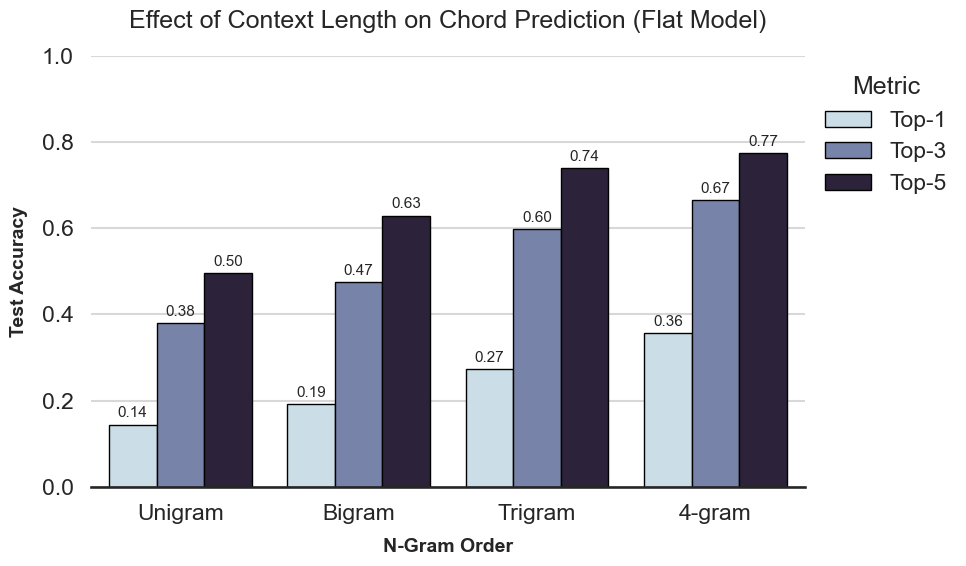

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

print("Ensuring counts include 4-grams...")
simplified_n_gram_counts = count_n_grams(train_chords, 4)

def get_probs(n, counts_obj):
    try:
        df_group = counts_obj.get_group(n).reset_index().copy()
        return compute_ngram_prob_from_df(df_group, n=n, alpha=1.0, input_data="simplified")
    except KeyError:
        return None

unigram_probs = compute_unigram_prob_from_df(simplified_n_gram_counts.get_group(1).reset_index().copy(), input_data="simplified")
bigram_probs = get_probs(2, simplified_n_gram_counts)
trigram_probs = get_probs(3, simplified_n_gram_counts)
fourgram_probs = get_probs(4, simplified_n_gram_counts)

#Evaluate on Test Set
results_data = []
models = [
    ("Unigram", 1, unigram_probs),
    ("Bigram", 2, bigram_probs),
    ("Trigram", 3, trigram_probs),
    ("4-gram", 4, fourgram_probs)
]

print("Evaluating on TEST set...")
for name, n, probs in models:
    if probs is None: continue
    print(f"Evaluating {name}...")
    _, t1, t3, t5 = evaluate_on_test_set(test_datasets["simplified"], n, probs)
    
    results_data.append({"Model": name, "K": "Top-1", "Accuracy": t1})
    results_data.append({"Model": name, "K": "Top-3", "Accuracy": t3})
    results_data.append({"Model": name, "K": "Top-5", "Accuracy": t5})

df_results = pd.DataFrame(results_data)
print("\nResults Table:")
print(df_results)

# Plotting
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=df_results,
    x="Model",
    y="Accuracy",
    hue="K",
    palette="ch:s=.25,rot=-.25", 
    edgecolor="black",
    linewidth=1,
    errwidth=0
)

# Polish the Chart
sns.despine(left=True)
ax.yaxis.grid(True, linestyle='-', alpha=0.3, color='gray')
ax.xaxis.grid(False)

plt.title("Effect of Context Length on Chord Prediction (Flat Model)", fontsize=18, pad=20)
plt.xlabel("N-Gram Order", labelpad=10, fontsize=14, fontweight='bold')
plt.ylabel("Test Accuracy", labelpad=10, fontsize=14, fontweight='bold')
plt.ylim(0, 1.0) 

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=11, padding=3)

plt.legend(title="Metric", bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.tight_layout()

# Save and Show
plt.savefig("chords_flat_model_accuracy.svg", format="svg", bbox_inches='tight')
plt.show()